# Project term

Camilo ROMERO <br>
@Eurecom <br>
Data Science - *Fall 2019*

# Title: *GP Inference with Random Features*

## Introduction
Gaussian Processes presents a great advantage for non-parametric modeling. Unfortunately its use is limited because it requires the invert of a matrix when inference. In this notebook, a methodology is presented to overcome the problems by linearizing inference operations through the transformation of the kernel. This methodology allows to accelerate the training through the transformation to a low dimension kernel in order to apply fast linear methods.


## Motivation
Kernel machines such as support vector machines, gaussian processes and more are attractive because they allow to approximate any function with few training data. Unfortunately these methods have the disadvantage of not being scalable and therefore different methodologies have been proposed to overcome this problem.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D

plt.style.use(['seaborn-white'])

The function that is going to approximate is indicated below. It is in a 2D domain between [0,1]

In [2]:
# Number of samples.
n_samples = 100

nx1 = nx2 = np.linspace(0, 1, n_samples).reshape(-1,1)
X1, X2 = np.meshgrid(nx1, nx2)

# real functions.
def func_eval(x1, x2, theta=np.pi/6):
    '''
    The following function is used to compute
    the function value for training points
    '''
    # Case 1 - 2 dimension.
    xr_0 = np.cos(theta)*x1 + np.sin(theta)*x2
    xr_1 = -np.sin(theta)*x1 + np.cos(theta)*x2
    
    return np.log(np.sin(2.5*np.pi*xr_0) + 1.5*x1 + 2*xr_1**2 + 1)

The following section details the actual function to approximate.

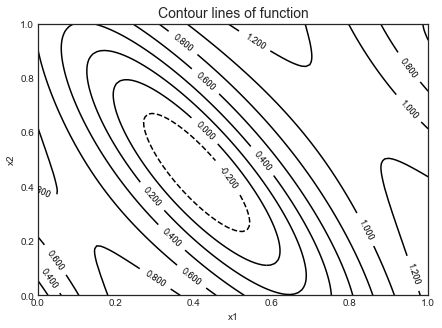

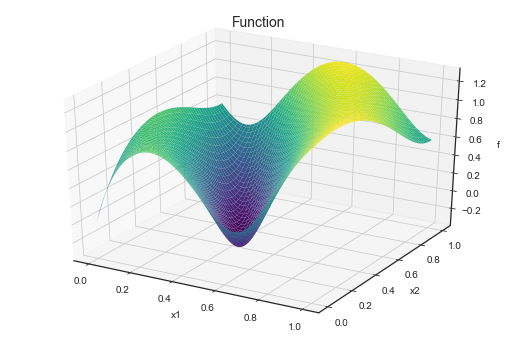

In [3]:
# Eval function case 1.
f = func_eval(X1, X2)

# plot contour function.
plt.figure(figsize=(7, 5))
CS = plt.contour(X1, X2, f, 10, colors='k')
plt.clabel(CS, fontsize=9, inline=1)
plt.title('Contour lines of function', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Plot
plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, f, cmap='viridis')
ax.set_title('Function', fontsize=14)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
# ax.view_init(20,30)
plt.show()

GP inference requires as an input a set of independend values of $x$ where you want to get the function values. In this case the predicted values are the grid points defined at the beginning of the notebook. 

In this case, the number of points for the inference has increased notably to see the behavior of the new inference method. Normally at this level of number of points, the traditional GP inference methodology would take a lot because the inversion of a mtatrix is required.

In [4]:
# Create test points.
xpred = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
print('Test point shape: {}'.format(xpred.shape))

Test point shape: (10000, 2)


For the training set, we randomly select certain numbers of points of the test grid to later inferred with them.

Training observed values shape (700, 2)

[[0.52525253 0.23232323]
 [0.4040404  0.04040404]
 [0.51515152 0.74747475]
 [0.63636364 0.06060606]
 [0.8989899  0.1010101 ]]

Target observed values shape (700, 1)

[[-0.19701909]
 [ 0.63893048]
 [ 0.80289188]
 [ 0.10108741]
 [ 1.04267885]]


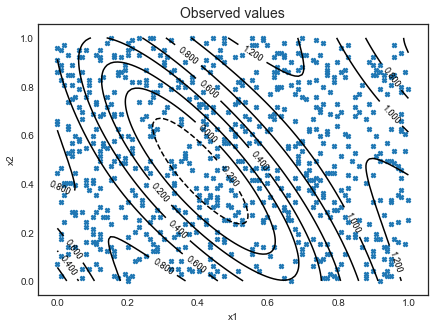

In [5]:
# Randomly sample from Xpred.
n_samples = 700
obs_X = xpred[np.random.choice(xpred.shape[0], n_samples, replace=False), :]

print ('Training observed values shape {}\n'.format(obs_X.shape))
print (obs_X[:5])
print ()


# target value for training data.
obs_F = func_eval(obs_X[:,0], obs_X[:,1]).reshape(-1,1)

print ('Target observed values shape {}\n'.format(obs_F.shape))
print (obs_F[:5])

# plot original function.
plt.figure(figsize=(7, 5))
CS = plt.contour(X1, X2, f, 10, colors='k')
plt.clabel(CS, fontsize=9, inline=1)
plt.title('Contour lines of function', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')

# plot training pts.
plt.scatter(obs_X[:,0], obs_X[:,1], marker='X', s=20)
plt.title('Observed values', fontsize=14)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Kernel approximation
The following section an approach to approximate a kernel by approaching in low dimesion by the number of random features is presented. The idea is based on Bochner's theorem that establishes that any continuous kernel is positive definite if and only if $k(\delta)$ is the fourier transformation of a non-negative measure.

\begin{equation*}
k(x-y) = \int_{R^d} p(\omega) \exp^{j\omega'(x-y)} d\omega
\end{equation*}

Where $p(\omega)$ is a non-negative measure such as a gaussian for the case of the gasussian kernel and $\omega$ depicts the frequencies. After computing the integral, in general the rbf kernal is reduced to the form:

\begin{equation*}
k_{rbf}(x_i, x_j) \approx \frac {1}{N_{RF}} \sum_{r=1}^{N_{RF}} z(x_i|\tilde{\omega_r})^T z(x_j|\tilde{\omega_r})
\end{equation*}

\begin{equation*}
z(x|\omega_r) = [cos(x^T \omega), sin(x^T \omega)]
\end{equation*}

\begin{equation*}
\tilde{\omega_r} = p(\omega)
\end{equation*}

First of all, the number of random features will be required for the methodology. In our case we defined it as N_rf It must be remembered that in a kernel there are an infinite number of features, so a large value will approximate the kernel in a better way but will penalize the computation time.

In [6]:
# Random features samples
N_rf = 200

# Length scale
lscl = 4.56390567e-01

# Prior standard deviation
var_prior = 2.00000000e+00
var_noise = 2.45599725e-04

n_train, dim = obs_X.shape[0], obs_X.shape[1]

Subsequently, a sampling of a non-negative measure is performed, such as a Gaussian. It must be indicated that the obtained values must have the same dimension as the values of $x$.

In [7]:
var_omega = np.sqrt(2)/lscl

# W random samples.
omega = var_omega * np.random.multivariate_normal(np.zeros(dim), np.identity(dim), N_rf)
print ('Omega shape:{} - training data shape:{}'.format(omega.shape, obs_X.shape))

Omega shape:(200, 2) - training data shape:(700, 2)


Then the linearization $z(x|\omega)$ for the training set is created. It must be remembered that the matrix is doubled because it is required now the part of $cos$ and $sin$.

In [8]:
train_inner_prod = np.matmul(obs_X, omega.T)

# z(x|w) = [cos(x,w) sin(x,w)]
phi_cos, phi_sin = np.cos(train_inner_prod), np.sin(train_inner_prod)
phi_train = np.hstack((phi_cos, phi_sin))

To see how effective the approach of the kernel is, the two methodologies are compared below.

In [9]:
# Guassian Kernel
def gaussian_kernel(x,                # x values (N,1)
                    y,                # y values (N,1)
                    lscl=None,        # l param. for RBF.
                    var=None):        # var param. for RBF.
    
    # Distance between all points.
    dist = distance.cdist(x, y, 'euclidean')
    
    # RBF w/o constrains (length NxN (#pts,#pts))
    return np.exp(-lscl**-2 * dist**2) * var

# Test gaussian kernel.
K = gaussian_kernel(obs_X, obs_X, lscl, var_prior)

print ('Original Kernel')
print ('---------------')
print ('Kernel (training pts) shape {}\n'.format(K.shape))
print(pd.DataFrame(K).iloc[:5, :5])

Original Kernel
---------------
Kernel (training pts) shape (700, 700)

          0         1         2         3         4
0  2.000000  1.561703  0.559102  1.636094  0.941548
1  1.561703  2.000000  0.170956  1.540429  0.606168
2  0.559102  0.170956  2.000000  0.193511  0.132579
3  1.636094  1.540429  0.193511  2.000000  1.425006
4  0.941548  0.606168  0.132579  1.425006  2.000000


In [10]:
kernel_appx = (var_prior/N_rf) * np.matmul(phi_train, phi_train.T)

print ('Kernel Approximation')
print ('--------------------')
print ('Kernel appox (training pts) shape {}\n'.format(kernel_appx.shape))
print(pd.DataFrame(kernel_appx).iloc[:5, :5])

Kernel Approximation
--------------------
Kernel appox (training pts) shape (700, 700)

          0         1         2         3         4
0  2.000000  1.576630  0.520578  1.665145  1.058855
1  1.576630  2.000000  0.180416  1.579385  0.635966
2  0.520578  0.180416  2.000000  0.044097 -0.046128
3  1.665145  1.579385  0.044097  2.000000  1.466585
4  1.058855  0.635966 -0.046128  1.466585  2.000000


It can be seen that the approximate kernel resembles the function previously defined. This would allow us to treat the inference operations in line without depending on the covariance matrix, which is very expensive to evaluate after a few thousand points.

The same process is applied for the test set becuase all the previous computation is required for the inference.

In [11]:
test_inner_prod = np.matmul(xpred, omega.T)

# z(x|w) = [cos(x,w) sin(x,w)]
phi_cos, phi_sin = np.cos(test_inner_prod), np.sin(test_inner_prod)
phi_test = np.hstack((phi_cos, phi_sin))

## Inference with Random Features
Finally we have the part of the inference with random features. Due to the kernel is approximated to trigonometric expressions, the inference of the linear bayesian regression can be used to make the predictions.

\begin{equation*}
\mathbb{E}(y_*) = \Phi(x_*)^T A^{-1} \Phi_f y
\end{equation*}

\begin{equation*}
\mathbb{V}(y_*) = \sigma_n^2 + \sigma_n^2 \Phi(x_*)^T A^{-1} \Phi(x_*)
\end{equation*}

Where:
\begin{equation*}
A = \Phi_f \Phi_f^T + \frac {m\sigma_n^2}{\sigma_o^2} I_{2m}
\end{equation*}

In [12]:
# Inference.
A = np.matmul(phi_train.T, phi_train) + (N_rf * var_prior/var_noise)*np.identity(2*N_rf)
A.shape

# Mean and variance predictions.
mean_pred = np.matmul(phi_test, np.matmul(np.linalg.inv(A), np.matmul(phi_train.T, obs_F)))
var_pred = var_prior + var_prior * np.matmul(phi_test ,np.matmul(np.linalg.inv(A), phi_test.T))
# var_diag = np.diag(var_pred)

Finally the result is plotted to be compared with the actual result of the function.

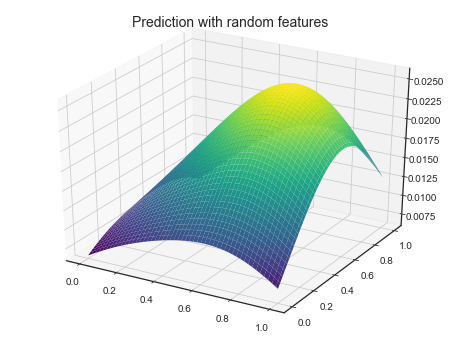

In [13]:
# Plot
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, mean_pred.reshape(X1.shape), cmap='viridis')
# ax.view_init(30,45)
plt.title('Prediction with random features', fontsize=14)
plt.show()

# Conclusion
In this notebook a methodology was presented to approximate a Gaussian Process by simply approximating the kernel into a low dimension based on the Bochner's theorem. The transformation of the kernel under this theorem allows us to make inferences similar to those that would be done in trigonometric linear bayesian. The great advantage is that the linear operations are scalable in comparison with the methodology of inference traditions of the Gaussian process.

It can easily be seen that the degree of precision of the prediction will depend on the number of random features defined since this number is infinite in a normal GP.